In [7]:
import numpy as np
import torch
from kitti.kitti_dataset import KittiDataset
import yaml
from easydict import EasyDict
from pathlib import Path
%matplotlib inline

In [8]:
cfg_path = Path("../kitti/cfg/kitti_dataset.yaml")
with open(cfg_path, "rb") as f:
    cfg = EasyDict(yaml.load(f))
dataset = KittiDataset(cfg, ["Car"])

<ipython-input-8-892357587d32>:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = EasyDict(yaml.load(f))


# Visualize Data

In [9]:
from basic.utils.vis_utils import VisualWindow
from kitti.io.kitti_io import KittiIo
import matplotlib.pyplot as plt
test_idx = 77

In [10]:
test_data = dataset[test_idx]
kitti_reader = KittiIo(Path(cfg.DATA_PATH) / "training")
idx = test_data['frame_id']
calib = kitti_reader.read_calibration(idx)
gt_boxes = test_data['gt_boxes']
print(f"test frame_id:{idx}")

test frame_id:006155


In [11]:
anno = kitti_reader.read_label(idx)
for a in anno:
    print(a.cls_type, end=" ")
    print(a.box2d)
boxes2d = [a.box2d for a in anno]

Car [680.22 189.59 800.   275.75]
Car [487.42 189.01 531.91 217.99]
Car [345.08 195.9  454.41 265.14]
Car [404.36 191.66 486.31 243.51]
Car [ 62.   211.17 340.29 341.36]
DontCare [527.27 181.27 578.35 196.94]
DontCare [581.6  179.28 618.16 189.9 ]
DontCare [625.19 177.1  674.19 193.81]


### 图像画框

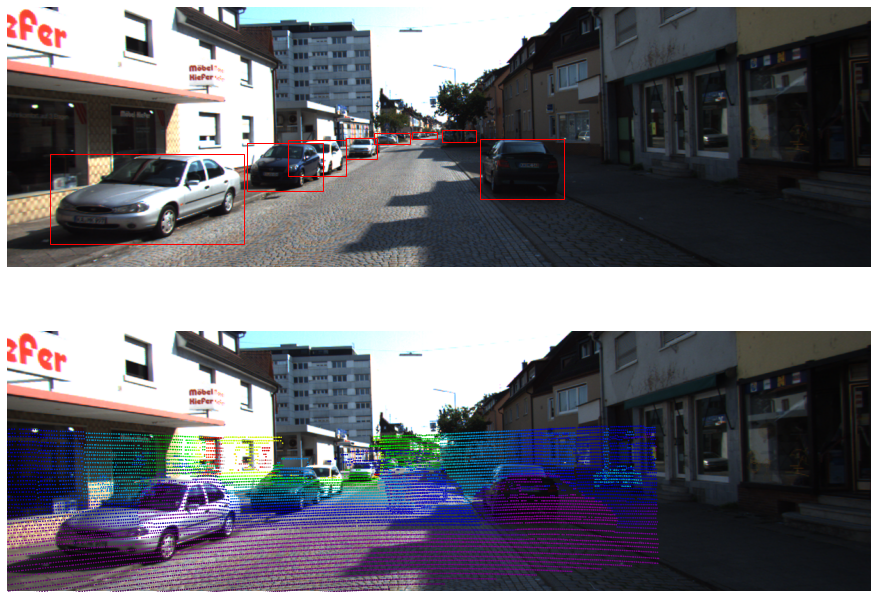

In [12]:
# 图像画框
raw_pc = kitti_reader.read_velodyne_bin(idx)
pc = test_data['points']
img = kitti_reader.read_image(idx)
img_shape = list(img.shape)
img_window = VisualWindow(mode='top_bot', img_shape=img_shape)
# 画图
img_window.draw_img(img)
# 画box2d
img_window.draw_boxes2d_on_img(boxes2d)
# 画点云投影
img_window.draw_point_cloud_on_img(pc[:, :3], calib)
# img_window.draw_point_cloud_in_img(raw_pc[:, :3], calib)

### 俯视图BEV画框

In [13]:
# 原始点云
raw_pc = kitti_reader.read_velodyne_bin(idx)
# 预处理后的点云，点云坐标系
pc = test_data['points']
# Camera Coordinate
pc_cam = calib.points_lidar_to_camera(pc[:, :3])
# Pixel Coordinate
pts_img, pts_cam_depth = calib.points_lidar_to_pixel(pc[:, :3])
pc_img = np.concatenate((pts_img, pts_cam_depth[:, np.newaxis]), axis=-1)
pc_cam

array([[-10.386687  ,   1.3104764 ,   9.157046  ],
       [ -0.17975725,   0.9883215 ,  34.462444  ],
       [ -6.208756  ,   1.6804786 ,   4.1307015 ],
       ...,
       [  0.12274822,   1.9980958 ,  13.605375  ],
       [-11.8633995 ,  -0.57855225,   9.500361  ],
       [-10.991944  ,   0.95216036,   8.25898   ]], dtype=float32)

In [14]:
pc_img

array([[-203.90927  ,  276.05502  ,    9.157046 ],
       [ 607.049    ,  193.53728  ,   34.462444 ],
       [-463.79846  ,  466.13712  ,    4.1307015],
       ...,
       [ 619.2411   ,  278.77924  ,   13.605375 ],
       [-286.64304  ,  128.89938  ,    9.500361 ],
       [-345.1951   ,  255.97968  ,    8.25898  ]], dtype=float32)

#### 2d散点图表示

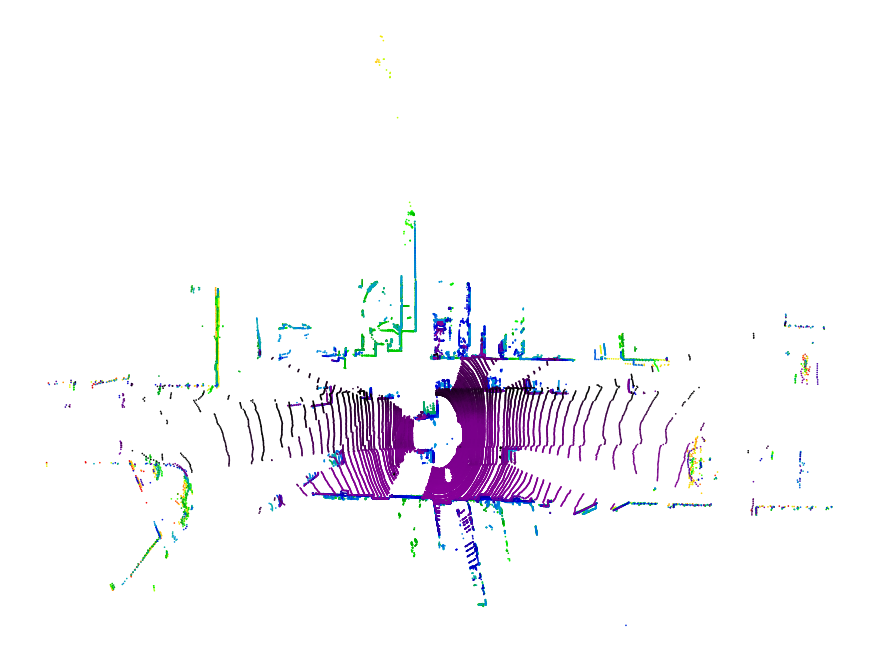

In [15]:
bev_window = VisualWindow(mode='bev')
bev_window.draw_bev(raw_pc, is_img=False, pc_in_point_coord=True, depth_range=[-2, 5])

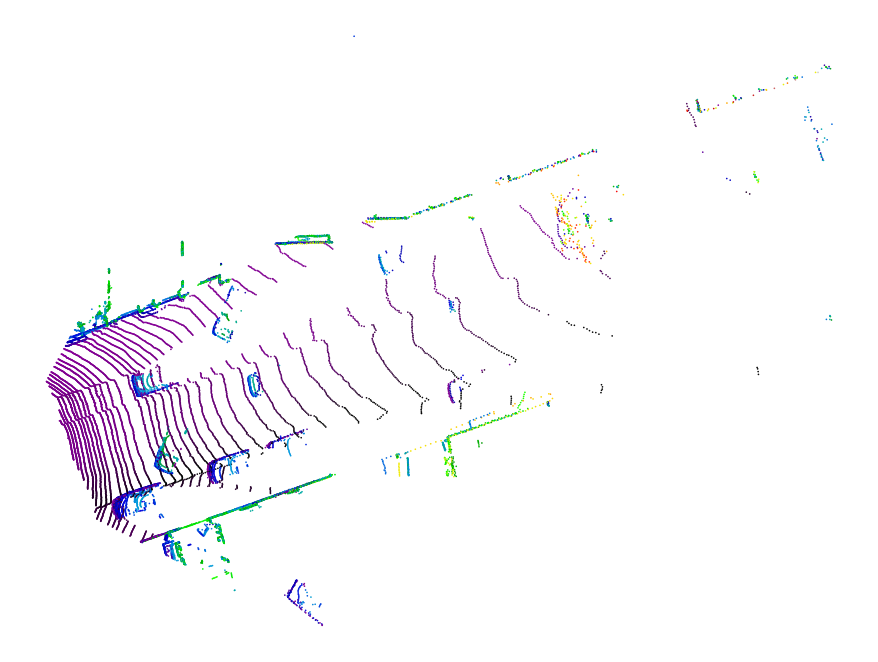

In [16]:
bev_window = VisualWindow(mode='bev')
bev_window.draw_bev(pc, is_img=False, pc_in_point_coord=True, depth_range=[-2, 5])

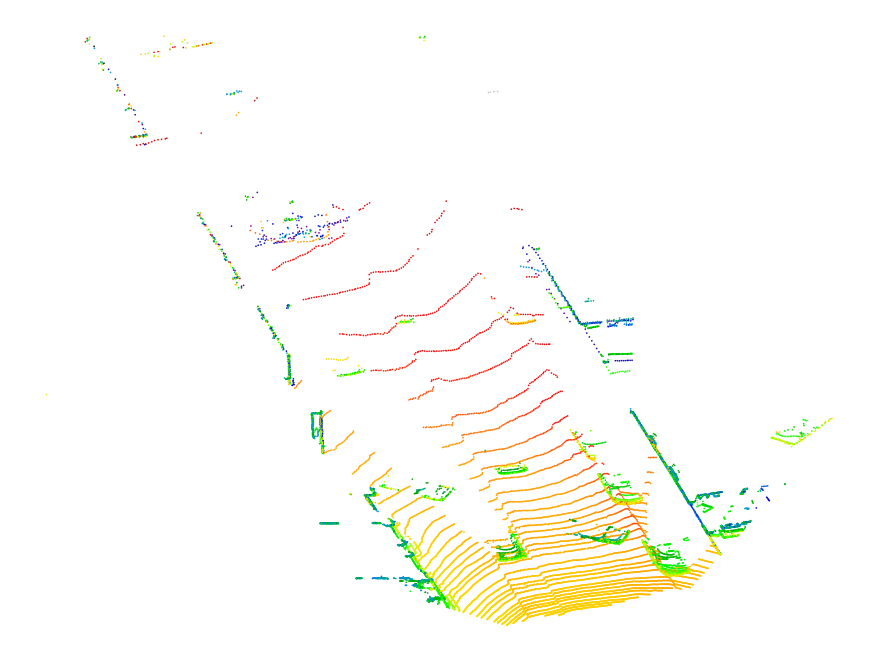

In [17]:
bev_window = VisualWindow(mode='bev')
bev_window.draw_bev(pc_cam, is_img=False, pc_in_point_coord=False)

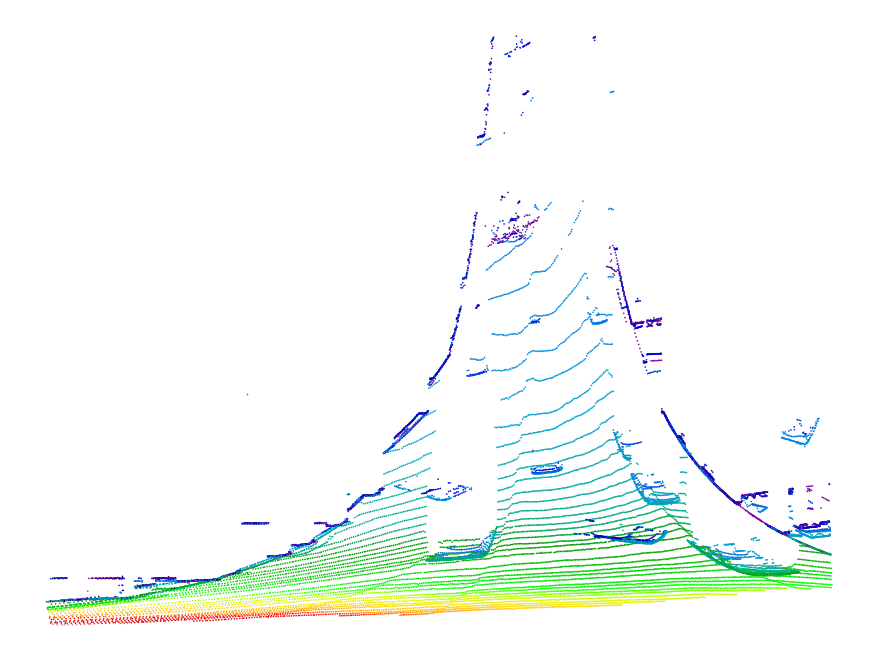

In [18]:
bev_window = VisualWindow(mode='bev')
bev_window.draw_bev(pc_img, is_img=False, pc_in_point_coord=False)

#### 图像表示

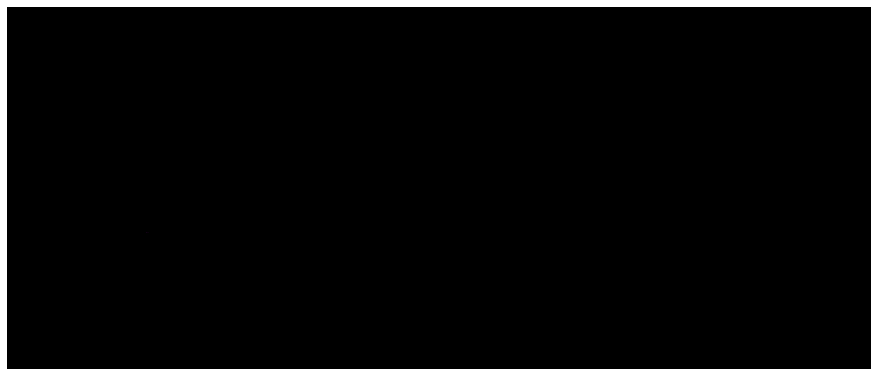

In [19]:
from basic.utils.vis_utils import convert_bev_point2img
bev_window = VisualWindow(mode='bev')
bev_img = convert_bev_point2img(raw_pc, res=0.1, coordinate='Point')
bev_window.bev_axes.set_ylim(0, bev_img.shape[0])
bev_window.draw_bev(bev_img, is_img=True)

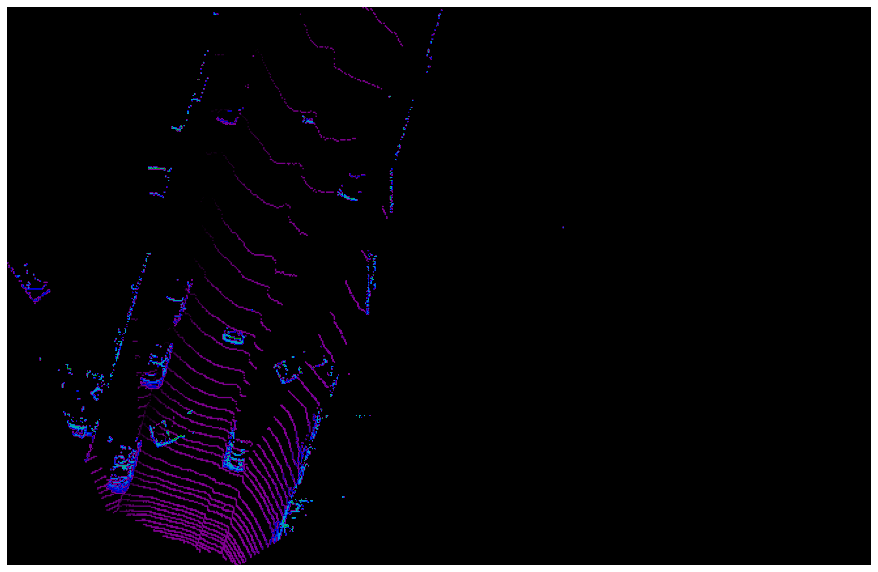

In [20]:
bev_window = VisualWindow(mode='bev')
bev_img = convert_bev_point2img(pc, res=0.1, coordinate='Point')
bev_window.bev_axes.set_ylim(0, bev_img.shape[0])
bev_window.draw_bev(bev_img)

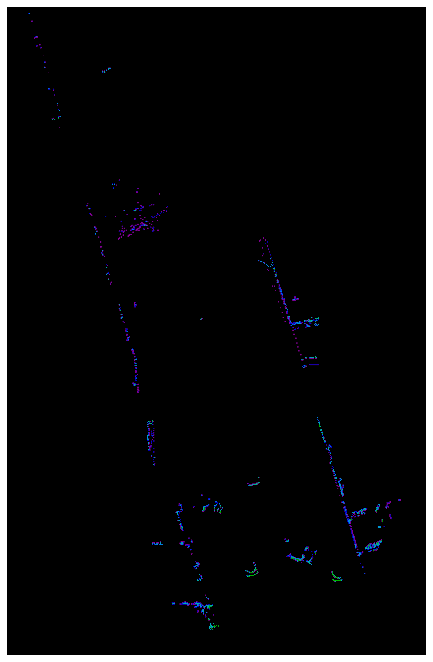

In [21]:
bev_window = VisualWindow(mode='bev')
bev_img = convert_bev_point2img(pc_cam, res=0.1,cam_off=None,coordinate='Camera')
bev_window.bev_axes.set_ylim(0, bev_img.shape[0])
bev_window.draw_bev(bev_img)

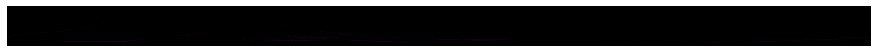

In [22]:
bev_window = VisualWindow(mode='bev')
bev_img = convert_bev_point2img(pc_img, res=0.1,cam_off=[calib.cu, calib.cv],coordinate='Pixel')
bev_window.bev_axes.set_ylim(0, bev_img.shape[0])
bev_window.draw_bev(bev_img)

# 3D点云画框

In [23]:
boxes3d = test_data['gt_boxes']
print("boxes3d shape:", boxes3d.shape)
boxes3d

boxes3d shape: (11, 8)


array([[13.497401  ,  6.4085445 , -1.0354717 ,  3.8160145 ,  1.660017  ,
         1.4272097 ,  0.27342817,  1.        ],
       [40.040337  ,  5.8651333 , -1.2538394 ,  4.018456  ,  1.7814816 ,
         1.4474537 , -2.8297572 ,  1.        ],
       [19.776955  ,  0.14379855, -1.2224569 ,  3.9880896 ,  1.6296508 ,
         1.5081862 , -2.8497572 ,  1.        ],
       [24.762331  ,  1.5591801 , -1.1831546 ,  3.9476016 ,  1.680261  ,
         1.4980642 , -2.8197572 ,  1.        ],
       [12.006609  , -2.3943756 , -1.2239841 ,  4.281629  ,  1.5992846 ,
         1.3259891 , -2.8397572 ,  1.        ],
       [26.407679  , -9.598023  , -1.1367611 ,  4.1095543 ,  1.680261  ,
         1.2855009 , -0.5965718 ,  1.        ],
       [23.032614  ,  6.4074073 , -0.6737728 ,  3.4212546 ,  1.7106273 ,
         1.3765994 ,  0.30342817,  1.        ],
       [34.358097  , 15.428344  , -0.5464329 ,  4.261385  ,  1.6094067 ,
         1.4474537 ,  0.38342816,  1.        ],
       [19.877344  , 11.141241  

In [26]:
%matplotlib
window3d = VisualWindow(mode='3d')
window3d.draw_point_cloud(raw_pc)
window3d.draw_boxes3d(boxes=boxes3d[:, :7], format='center')
plt.show()

Using matplotlib backend: Qt5Agg
